In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/DeOldify/


/content/drive/My Drive/DeOldify


In [4]:
from deoldify import device
from deoldify.device_id import DeviceId
device.set(device=DeviceId.GPU0)
import torch
print(torch.cuda.is_available())


True


In [5]:
import os
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
!pip install tensorboardx
from fastai.vision.gan import *
from deoldify.generators import *
from deoldify.critics import *
from deoldify.dataset import *
from deoldify.loss import *
from deoldify.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


NumExpr defaulting to 2 threads.
To use this tracker, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results


NameError: ignored

In [ ]:

import warnings


warnings.simplefilter("ignore")

path = Path('./manga_data')
path_hr = path/'train_color'
path_lr = path/'train'

proj_id = 'ArtisticModel'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 1.5
pct_start = 1e-8

In [ ]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr,
                             random_seed=None, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2., resize_method=ResizeMethod.PAD, padding_mode='border'), size=sz)
       .databunch(bs=bs).normalize(imagenet_stats))

    return data

def create_training_images(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)

def save_preds(dl):
    i=0
    names = dl.dataset.items

    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

In [ ]:
if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 246MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


epoch,train_loss,valid_loss,time
0,4.991409,#na#,01:03
1,4.945967,#na#,00:49
2,4.826105,#na#,00:51
3,4.967777,#na#,00:49


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,4.901248,4.746462,00:56
1,4.883008,4.648894,00:57
2,4.822550,4.535440,00:57
3,4.741869,4.466867,00:58
4,4.671200,4.422973,00:57
5,4.620960,4.398460,00:57
6,4.581750,4.365698,00:57
7,4.547264,4.356231,00:59
8,4.528297,4.339751,00:56
9,4.497402,4.329682,00:55


epoch,train_loss,valid_loss,time
0,4.484140,4.324948,00:58
1,4.453934,4.326669,00:58
2,4.434366,4.323548,00:59
3,4.419142,4.314138,00:58
4,4.419834,4.329813,00:59
5,4.413984,4.333085,00:58
6,4.403581,4.310433,00:58
7,4.378909,4.304828,00:59
8,4.367514,4.308475,01:00
9,4.360119,4.286926,00:59


epoch,train_loss,valid_loss,time
0,4.388551,4.278477,00:58
1,4.356836,4.281405,00:58
2,4.355857,4.266825,01:00
3,4.340841,4.293480,01:00
4,4.325238,4.234077,01:00
5,4.326883,4.238216,01:01
6,4.326423,4.248137,00:59
7,4.345805,4.290372,00:58


Epoch 8: early stopping


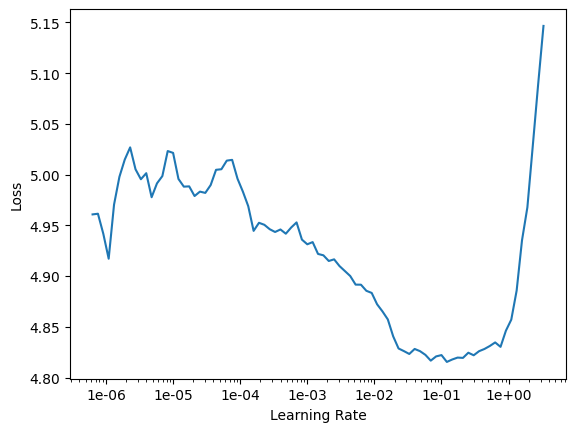

In [ ]:
from fastai.callbacks import EarlyStoppingCallback
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

bs = 5  # Increase batch size

# Progressive resizing: Start with a slightly larger size
sz = 300
data_gen = get_data(bs=bs, sz=sz, keep_pct=1.0)
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)
learn_gen.load('ColorizeArtistic_gen')
learn_gen.unfreeze()

# Find optimal learning rate
learn_gen.lr_find()
learn_gen.recorder.plot()

# Use the plot to choose a good learning rate.
lr = slice(1e-4, 1e-3)

# Gradient accumulation: Equivalent to batch size of 8
learn_gen.opt_func = partial(learn_gen.opt_func, accum_steps=2)  # Adjusted for the increased batch size

# Train with differential learning rates and weight decay
learn_gen.fit_one_cycle(10, lr, pct_start=0.8, wd=0.1)

# Increase size for the next round of training
sz = 450
data_gen = get_data(bs=bs, sz=sz, keep_pct=1.0)
learn_gen.fit_one_cycle(10, lr, pct_start=0.8, wd=0.1)

# Final size for the last round of training
sz = 600
data_gen = get_data(bs=bs, sz=sz, keep_pct=1.0)
learn_gen.fit_one_cycle(
    10,
    lr,
    pct_start=0.8,
    wd=0.1,
    callbacks=[EarlyStoppingCallback(learn_gen, monitor='valid_loss', min_delta=0.01, patience=3)]
)


In [1]:
learn_gen.save('manga_colorizer')

NameError: ignored

In [ ]:
from PIL import Image

learn_gen.load('manga_colorizer')

from PIL import ImageEnhance

import matplotlib.pyplot as plt
learn_gen.load('manga_colorizer')
def colorize_img(img_path):
    img = open_image(img_path)  # Open the image using FastAI's open_image
    p, img_hr, b = learn_gen.predict(img)  # Predict the colorized version
    fastai.vision.image.Image(img_hr).show(figsize=(8,8))  # Convert tensor to Image and then show


colorize_img('test_images/1img.jpg')


NameError: ignored